# Imports

In [1]:
!pip install pvlib
import pvlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 22.4 MB/s eta 0:00:00


# Define Park Class and POA Function

In [2]:
# Class
import pvlib

class PVPark:
    def __init__(self, name, latitude, longitude, altitude, tz, tilt, azimuth):
        self.location = pvlib.location.Location(latitude=latitude, longitude=longitude, altitude=altitude, tz=tz, name=name)
        self.tilt = tilt
        self.azimuth = azimuth

In [67]:
def get_poa(park, times, ghi_values):
    # Full time index in global time
    times = pd.to_datetime(times)

    # Get solar position
    solpos = park.location.get_solarposition(times)

    # GHI time series
    ghi = pd.Series(ghi_values, index=times)

    # Estimate DHI and DNI for the full time range
    dhi = pvlib.irradiance.erbs(ghi, solpos['zenith'], ghi.index)['dhi']
    dni = pvlib.irradiance.dni(ghi, dhi, solpos['zenith'])

    # Calculate POA for all time steps
    poa = pvlib.irradiance.get_total_irradiance(
        surface_tilt=park.tilt,
        surface_azimuth=park.azimuth,
        dni=dni,
        ghi=ghi,
        dhi=dhi,
        solar_zenith=solpos['zenith'],
        solar_azimuth=solpos['azimuth']
    )

    # Mask nighttime: set poa_global to 0 when sun is below horizon
    poa.loc[solpos['zenith'] >= 90, ['poa_global', 'poa_direct', 'poa_diffuse']] = 0

    return poa.reset_index(drop=True)


# Test for Different Parameters

In [35]:
def plot_irradiance(times, ghi):
    plt.figure(figsize=(10, 6))
    plt.plot(times, ghi)
    plt.title("Irradiance during a day")
    plt.xlabel("Time")
    plt.ylabel("Irradiance(W/m²)")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Azimuth

<ipython-input-35-3358205638>:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


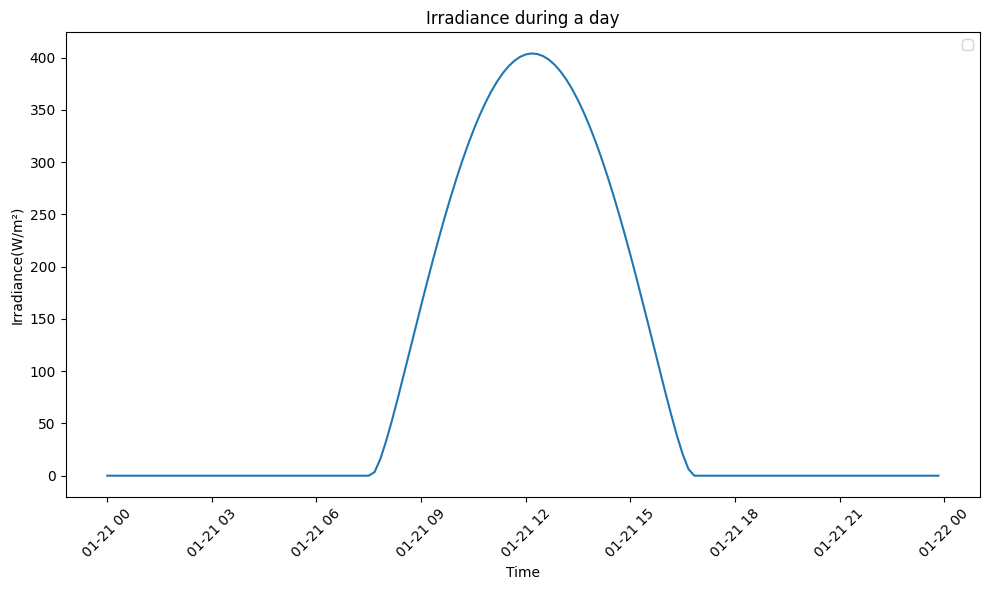

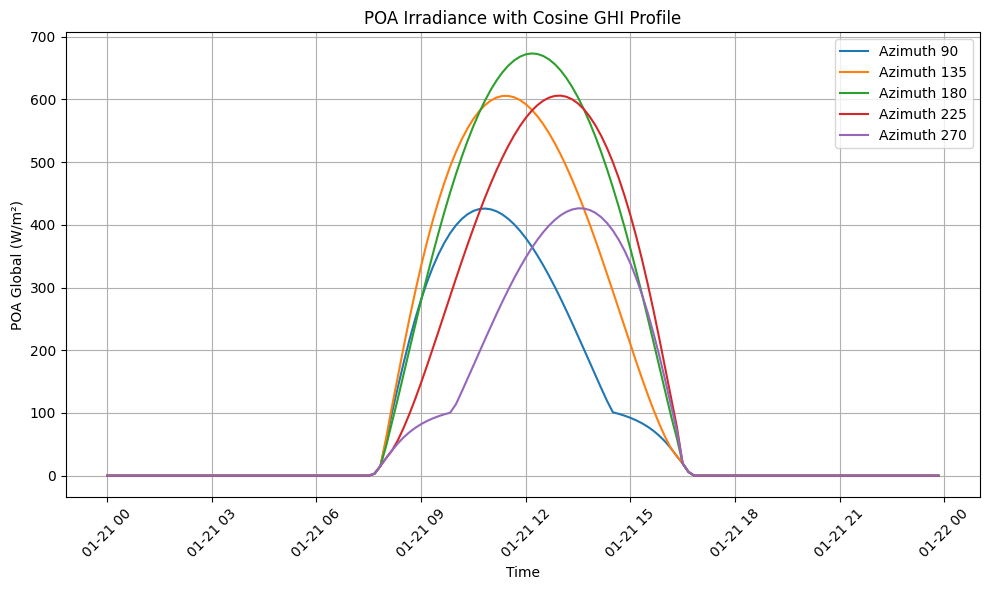

In [36]:
azimuths = [90, 135, 180, 225, 270]
park = PVPark(name="Park-"+str(az), latitude=45.0, longitude=0, altitude=None, tz='UTC', tilt=30, azimuth=az)
times = pd.date_range("2024-01-21 00:00", "2024-01-21 23:50", freq="10min", tz='UTC')
solpos = park.location.get_solarposition(times)
clearsky = park.location.get_clearsky(times, model='simplified_solis')
ghi = clearsky['ghi']
plot_irradiance(times, ghi)

results = {}
for az in azimuths:
    park = PVPark(name="Park-"+str(az), latitude=45.0, longitude=0, altitude=None, tz='UTC', tilt=30, azimuth=az)
    times=pd.Series(times)
    poa = get_poa(park, times, ghi)
    results[f"Azimuth {az}"] = poa['poa_global']

plt.figure(figsize=(10, 6))
for label, series in results.items():
    plt.plot(times, series, label=label)
plt.title("POA Irradiance with Cosine GHI Profile")
plt.xlabel("Time")
plt.ylabel("POA Global (W/m²)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

During this period (January 21), the sun follows a relatively low arc across the southern sky due to the winter season in the northern hemisphere. As a result, the solar elevation remains modest throughout the day, and the sun rises in the southeast and sets in the southwest. This favors south-facing panels (azimuth 180°), which align most closely with the solar path, thus receiving the highest total irradiance.



## Tilt

<ipython-input-35-3358205638>:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


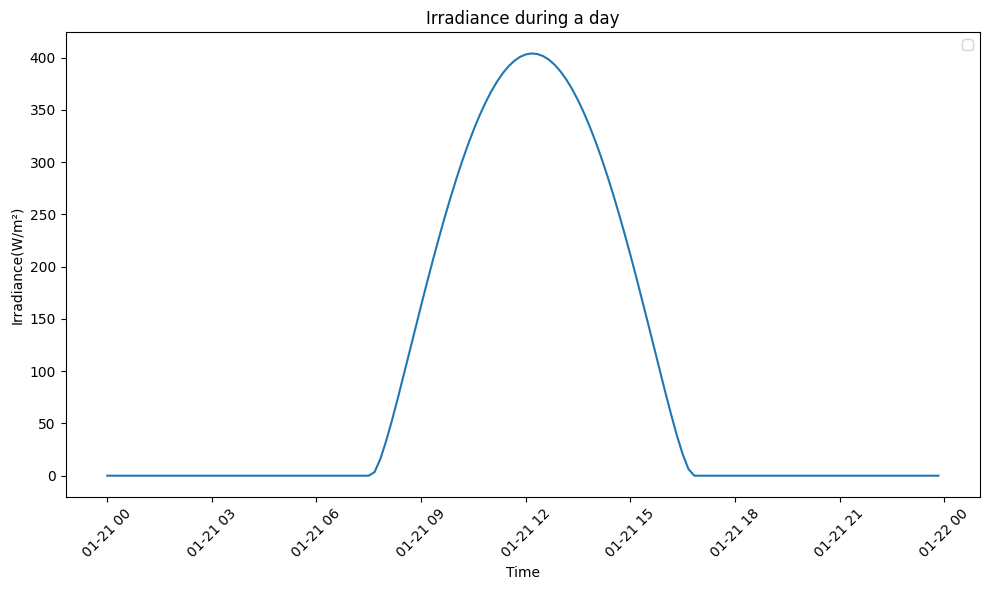

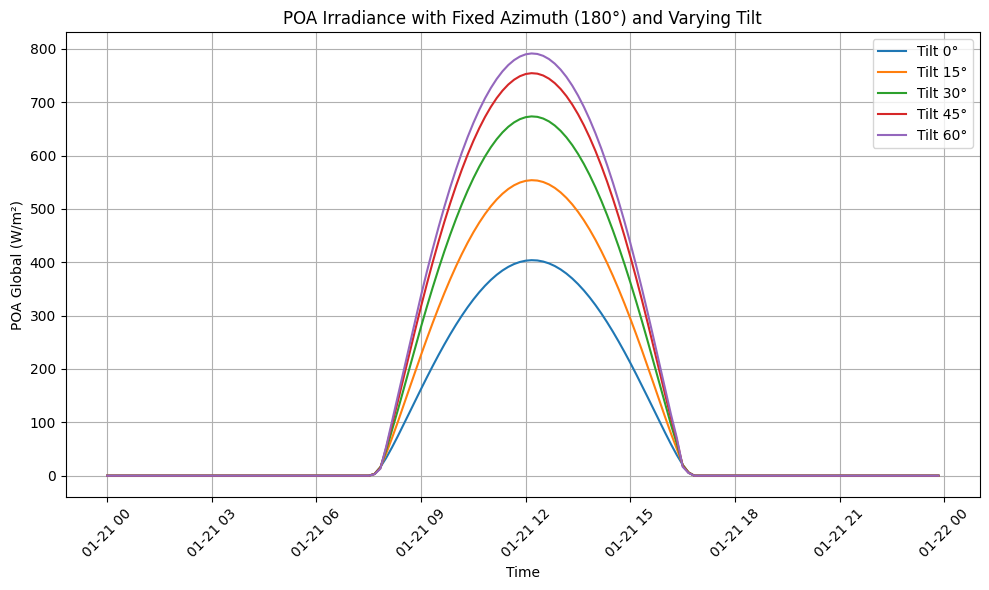

In [53]:
tilts = [0, 15, 30, 45, 60]

park = PVPark(name="Park-"+str(az), latitude=45.0, longitude=0, altitude=None, tz='UTC', tilt=None, azimuth=None)
times = pd.date_range("2024-01-21 00:00", "2024-01-21 23:50", freq="10min", tz='UTC')
solpos = park.location.get_solarposition(times)
clearsky = park.location.get_clearsky(times, model='simplified_solis')
ghi = clearsky['ghi']
plot_irradiance(times, ghi)

results = {}
for tilt in tilts:
    park = PVPark(name=f"Park-{tilt}", latitude=45.0, longitude=0, altitude=None, tz='UTC', tilt=tilt, azimuth=180)
    times=pd.Series(times)
    poa = get_poa(park, times, ghi)
    results[f"Tilt {tilt}°"] = poa['poa_global']

plt.figure(figsize=(10, 6))
for label, series in results.items():
    plt.plot(times, series, label=label)
plt.title("POA Irradiance with Fixed Azimuth (180°) and Varying Tilt")
plt.xlabel("Time")
plt.ylabel("POA Global (W/m²)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


This plot shows POA Global Irradiance on January 21 at latitude 45°N for a fixed south-facing (azimuth 180°) PV module with varying tilt angles. As the tilt increases from 0° to 60°, the POA also increases due to improved alignment with the sun’s low winter arc. The steeper the panel, the better it captures direct irradiance during this season. The highest POA occurs at 60° tilt, which most closely matches the midday solar elevation (~21°), highlighting the importance of tilt optimization for winter energy yield.

## Latitude

<ipython-input-35-3358205638>:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


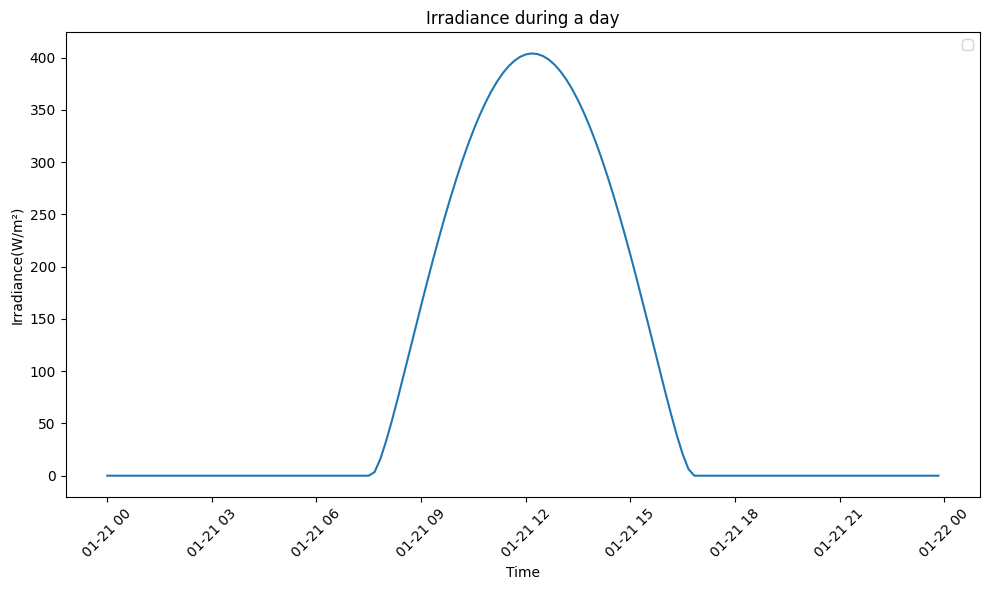

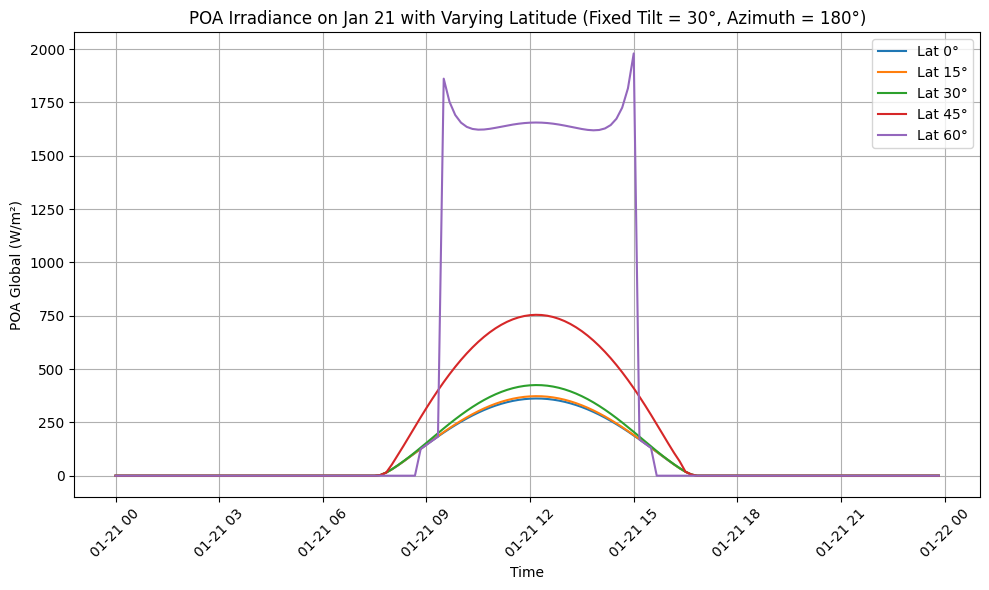

In [68]:
latitudes = [0, 15, 30, 45, 60]
results = {}

park = PVPark(name="Test Park", latitude=45.0, longitude=0, altitude=None, tz='UTC', tilt=None, azimuth=None)
times = pd.date_range("2024-01-21 00:00", "2024-01-21 23:50", freq="10min", tz='UTC')
solpos = park.location.get_solarposition(times)
clearsky = park.location.get_clearsky(times, model='simplified_solis')
ghi = clearsky['ghi']
plot_irradiance(times, ghi)


for lat in latitudes:
    park = PVPark(name=f"Park-{lat}", latitude=lat, longitude=0, altitude=None, tz='UTC', tilt=45, azimuth=180)
    poa = get_poa(park, times, ghi)
    results[f"Lat {lat}°"] = poa['poa_global']

# Plotting
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
for label, series in results.items():
    plt.plot(times, series, label=label)
plt.title("POA Irradiance on Jan 21 with Varying Latitude (Fixed Tilt = 30°, Azimuth = 180°)")
plt.xlabel("Time")
plt.ylabel("POA Global (W/m²)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()